# Spectra acquisiton
Control both the stepping motor and the camera from this notebook.

In [1]:
%pylab inline
!pip install git+https://github.com/fujiisoup/pyspectra.git

Populating the interactive namespace from numpy and matplotlib
  Cloning https://github.com/fujiisoup/pyspectra.git to c:\users\fujii\appdata\local\temp\pip-req-build-p7yx0mu6
  Created wheel for pyspectra: filename=pyspectra-0.0.1-py3-none-any.whl size=20072 sha256=38599e9c2ea63d3daf2ca89c44306b29c51e9342894cabd4ec5cff8a9e18e0b3
  Stored in directory: C:\Users\fujii\AppData\Local\Temp\pip-ephem-wheel-cache-po66ybzl\wheels\ff\a1\cf\c5105ce806bf39cb7ebcacfdea20bc1140bc703e680b3327ad
Successfully built pyspectra


In [2]:
from lab_control.spectrometer import thr640

In [3]:
from FLI import FLI
import numpy as np
import time
import logging
import csv
import xarray as xr
from os.path import join
import pyspectra

In [4]:
# logger
logger = thr640.logger
camera = FLI()
step_motor = thr640.THR640()

In [5]:
count=465000
step_motor.goto(count)
step_motor.waitUntilReady()

2021-01-04 18:01:36,815:INFO:getting status...
2021-01-04 18:01:43,691:INFO:Move to +465000
2021-01-04 18:01:43,796:INFO:getting status...
2021-01-04 18:01:49,847:INFO:getting status...


150000.0


<Figure size 432x288 with 0 Axes>

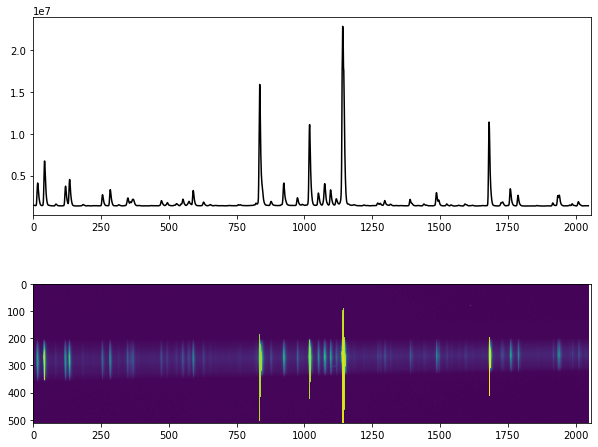

In [29]:
%run imaging_tool.py

exposure = 150 * 1e3 # ms
vbin = 1

attributes = {
    "temperature": camera.getTemperature(),
    "device_status": camera.getDeviceStatus(),
    "exposure": exposure,
    "frame_type": "light",
    "denryu": 3,
    "slit": "50㎛"
}

camera.setExposureTime(exposure)
camera.setVBin(vbin)
camera.setImageArea(10,0,2058,512//vbin)
time.sleep(.5)
camera.exposeFrame()
time.sleep(.1)
# load image
image_data = camera.grabFrame(out=np.empty((512//vbin,2048), np.uint16))
# convert to xarray
data = xr.DataArray(
    image_data, dims=["y", "x"], coords={"image_counter": 0}, attrs=attributes
)
# save data as NetCDF file
filepath = 'test.nc'
filepath = join(r'\\10.249.254.51\Public\Kuzmin\Experiments-Leprecon\Spectrometer\20210104_niihama_2',filepath)
data.to_netcdf(filepath)
plot_image(image_data)
print(exposure)

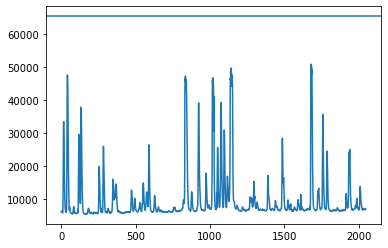

In [30]:
plot(data.max(axis=0))
axhline(2**16)

In [8]:
def fit(da):
  popt, perr = pyspectra.fit.singlepeak_fit(da['x'].values, da.values)
  return xr.Dataset({
      'A': popt[0], 'x0': popt[1], 'w': popt[2], 'y0': popt[3],
      'data': da,
      'fit': ('x', pyspectra.profiles.Gauss(da['x'].values, *popt))},
      coords={'x': da['x']})

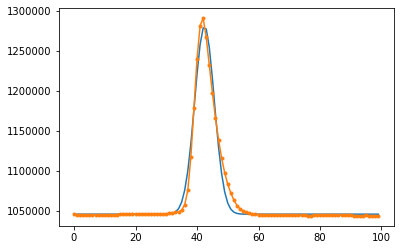

In [9]:
result = fit(data.sum('y').sel(x=slice(1100, 1200)))
plot(result['fit'])
plot(result['data'], marker='.')

# Read from file

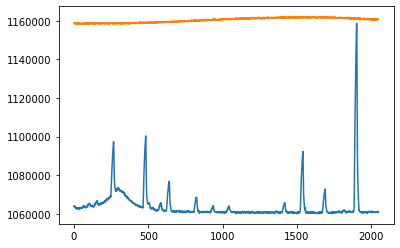

In [10]:
ds_disk = xr.open_dataset('cathode22A.nc')
a = ds_disk.to_array()
ds_disk.close()
plot(a[0].sum(axis=0))

ds_disk = xr.open_dataset('cathodebg.nc')
a = ds_disk.to_array()
ds_disk.close()
plot(a[0].sum(axis=0))

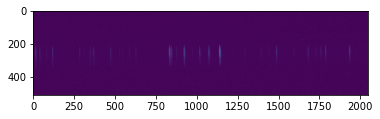

In [11]:
ds_disk = xr.open_dataset(filepath)
a = ds_disk.to_array()
ds_disk.close()
imshow(a[0])

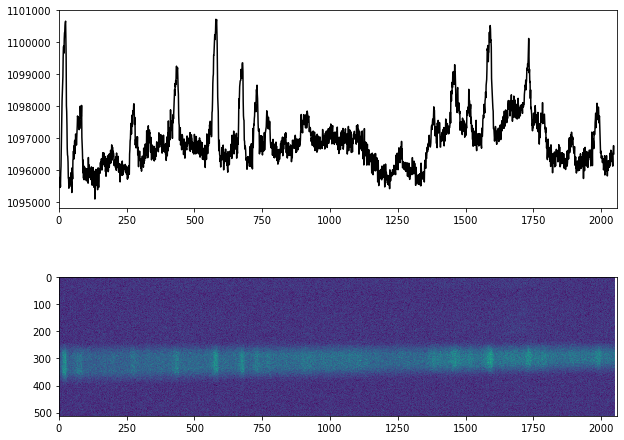

In [12]:
ds_disk = xr.open_dataset('test1.nc')
a = ds_disk.to_array()
ds_disk.close()
plot_image(a[0])

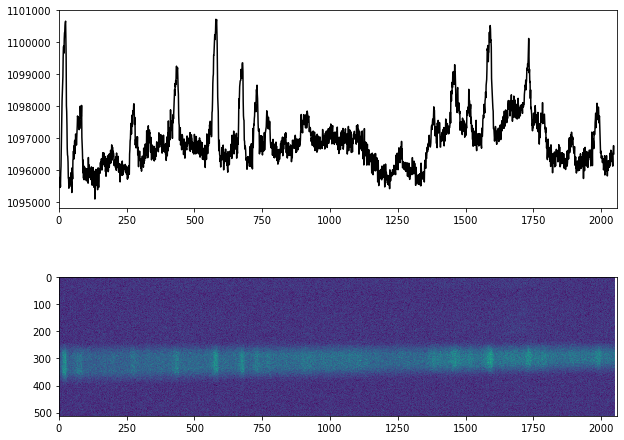

In [13]:
ds_disk = xr.open_dataset('test1.nc')
a = ds_disk.to_array()
ds_disk.close()
plot_image(a[0])

# Load and plot

In [14]:
import os
from os.path import join
%run imaging_tool.py


<Figure size 432x288 with 0 Axes>

In [15]:
basepath = r'\\10.249.254.51\Public\Kuzmin\Experiments-Leprecon\Spectrometer\20200826'
ls = os.listdir(basepath)

[(900, 1100), (900, 1100)]

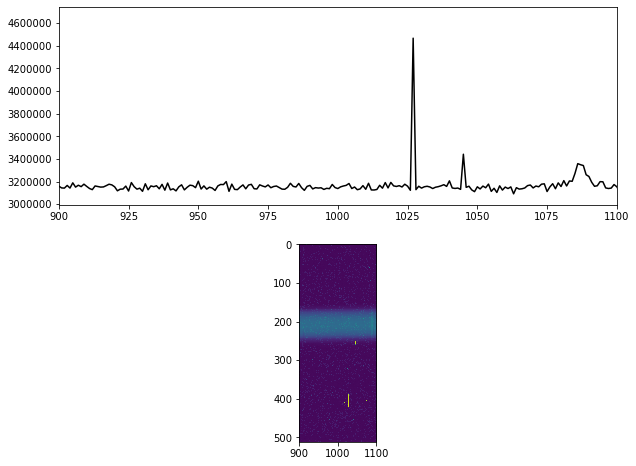

In [16]:
#### %run imaging_tool.py
i = 2
ls = sorted(os.listdir(basepath))
ls = [i for i in ls if 'Ar' in i]

f = ls[i]
fp = join(basepath, f)
data = xr.open_dataset(fp)
image_data = data.to_array()[0]
plot_image(image_data)
#[ax.axvline(1030,c='C3',ls='--') for ax in gcf().axes]
[ax.set_xlim(900,1100) for ax in gcf().axes]

(900, 1100)

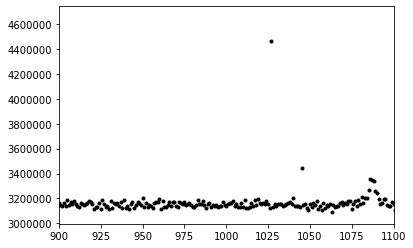

In [17]:
plot(image_data.sum(axis=0),'k.')
xlim(900,1100)